In [38]:
# 미환율, WTI유, 금, S&P500, 다우존스, 위안, 닛케이, 코스피, 나스닥, VIX

C:\Users\campus4D008\AppData\Local\Temp\ipykernel_16312\2253059954.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\campus4D008\AppData\Local\Temp\ipykernel_16312\2253059954.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\campus4D008\AppData\Local\Temp\ipykernel_16312\2253059954.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\campus4D008\AppData\Local\Temp\ipykernel_16312\2253059954.py:32: FutureWarning: YF.download() has changed argume

Epoch 1/30



C:\Users\campus4D008\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 214ms/step - accuracy: 0.2981 - loss: 0.0428 - val_accuracy: 0.4952 - val_loss: 0.0370
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 243ms/step - accuracy: 0.5079 - loss: 0.0351 - val_accuracy: 0.4762 - val_loss: 0.0362
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 212ms/step - accuracy: 0.5071 - loss: 0.0345 - val_accuracy: 0.5048 - val_loss: 0.0365
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.4501 - loss: 0.0342 - val_accuracy: 0.4857 - val_loss: 0.0366
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 209ms/step - accuracy: 0.4986 - loss: 0.0336 - val_accuracy: 0.4571 - val_loss: 0.0363
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 216ms/step - accuracy: 0.5008 - loss: 0.0337 - val_accuracy: 0.4762 - val_loss: 0.0355
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 236ms/step - accuracy: 0.4535 - loss: 0.0334 - val_accuracy: 0.4667 - val_loss: 0.0357
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 200ms/step - accuracy: 0.4641 - loss: 0.0337 - val_accuracy: 0.4286 - val_

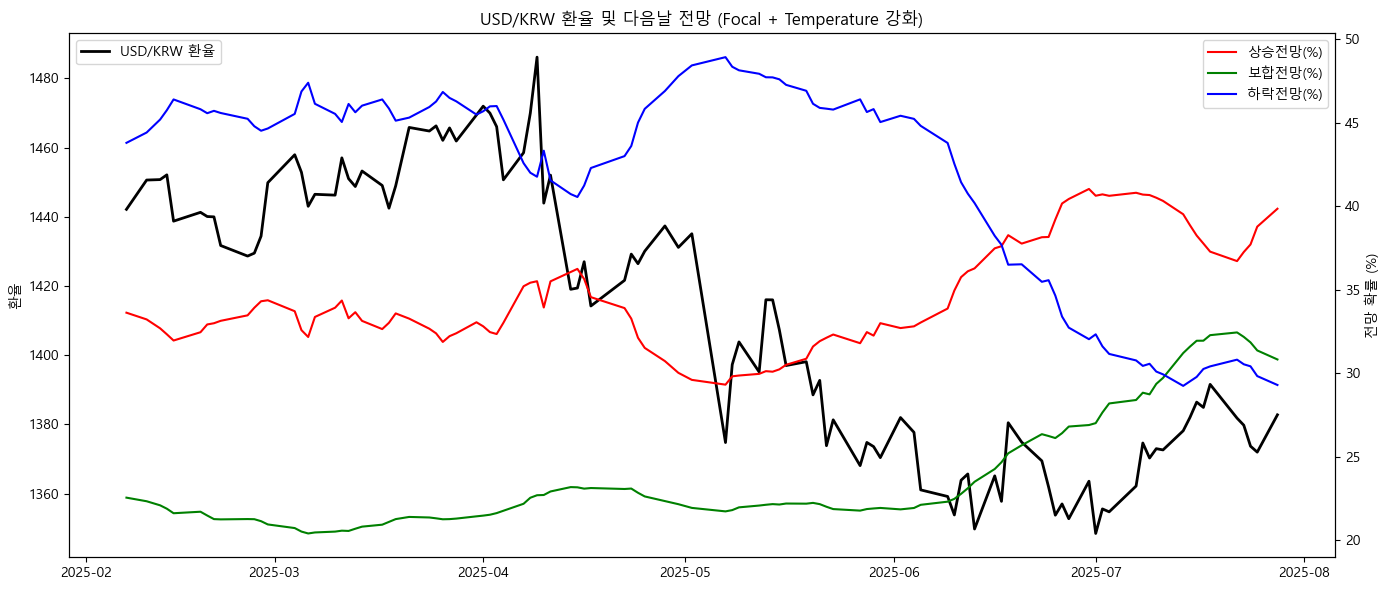

In [30]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# ✅ 설정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.run_functions_eagerly(True)

# ✅ 데이터 수집
start_date = '2023-01-01'
end_date = '2025-07-29'

tickers = {
    'KRW=X': '환율', 'CL=F': 'WTI유', 'GC=F': '금',
    '^GSPC': 'S&P500', '^DJI': '다우존스', 'CNY=X': '위안',
    '^N225': '닛케이', '^KS11': '코스피', '^IXIC': '나스닥', '^VIX': 'VIX'
}

df = pd.DataFrame()
for ticker, name in tickers.items():
    data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
    data.rename(columns={'Close': name}, inplace=True)
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')

df = df.dropna().reset_index()
df.rename(columns={'Date': '날짜'}, inplace=True)

# ✅ 기술적 지표 추가
df['MA20'] = df['환율'].rolling(window=20).mean()
df['STD20'] = df['환율'].rolling(window=20).std()
df['Upper'] = df['MA20'] + 2 * df['STD20']
df['Lower'] = df['MA20'] - 2 * df['STD20']
df['EMA12'] = df['환율'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['환율'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
delta = df['환율'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
ema_up = up.ewm(span=14, adjust=False).mean()
ema_down = down.ewm(span=14, adjust=False).mean()
rs = ema_up / ema_down
df['RSI'] = 100 - (100 / (1 + rs))

# ✅ 타깃: ±1원 기준 3분류
df['Target'] = df['환율'].shift(-1) - df['환율']
df['Target'] = df['Target'].apply(lambda x: 0 if abs(x) < 1 else (1 if x >= 1 else 2))
df = df.dropna().reset_index(drop=True)

# ✅ 피처 정의 및 스케일링
features = ['WTI유', '금', 'S&P500', '다우존스', '위안', '닛케이', '코스피', '나스닥', 'VIX',
            'MA20', 'Upper', 'Lower', 'MACD', 'Signal', 'RSI']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# ✅ 시퀀스 생성
def create_sequences(data, targets, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(targets[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(df[features].values, df['Target'].values, seq_len=30)
y_cat = to_categorical(y, num_classes=3)

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, shuffle=False)

# ✅ Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

# ✅ 모델 정의
model = Sequential([
    Bidirectional(LSTM(72, return_sequences=False)),
    Dropout(0.2),
    Dense(48, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss=focal_loss(), optimizer=Adam(0.0007), metrics=['accuracy'])

# ✅ 학습
model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=30, batch_size=32, verbose=1)

# ✅ 예측
logits = model.predict(X_val)

# ✅ Temperature 적용
def softmax_temperature(logits, T=0.7):
    exp_logits = np.exp(logits / T)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

probs = softmax_temperature(logits, T=0.7)

# ✅ 결과 병합
result = df.iloc[-len(probs):].copy()
result['상승전망(%)'] = probs[:,1] * 100
result['보합전망(%)'] = probs[:,0] * 100
result['하락전망(%)'] = probs[:,2] * 100
result['USD/KRW 환율'] = df['환율'].iloc[-len(probs):].values

# ✅ 시각화
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(result['날짜'], result['USD/KRW 환율'], color='black', label='USD/KRW 환율', linewidth=2)
ax2.plot(result['날짜'], result['상승전망(%)'], color='red', label='상승전망(%)')
ax2.plot(result['날짜'], result['보합전망(%)'], color='green', label='보합전망(%)')
ax2.plot(result['날짜'], result['하락전망(%)'], color='blue', label='하락전망(%)')

ax1.set_ylabel("환율")
ax2.set_ylabel("전망 확률 (%)")
plt.title("USD/KRW 환율 및 다음날 전망 (Focal + Temperature 강화)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xlabel("날짜")
plt.tight_layout()
plt.show()



---

### ✅ 환율 예측 모델 10줄 요약 발표문

1. 본 프로젝트는 USD/KRW 환율의 **다음날 방향(상승/보합/하락)** 을 예측하는 모델입니다.
2. 야후 파이낸스 데이터를 통해 환율과 주요 지수(금, 원유, 주가지수 등)를 수집했습니다.
3. 타깃은 ±1원 기준 3분류(상승/보합/하락)로 설정하여 분류 모델로 구성했습니다.
4. 입력 특성에는 기술적 지표(RSI, MACD, 볼린저 밴드 등)도 포함되었습니다.
5. 30일 간의 시계열 데이터를 기반으로 **Bidirectional LSTM 모델**을 학습시켰습니다.
6. 손실 함수로는 **Focal Loss**를 사용해 클래스 불균형에 대응했습니다.
7. 예측 확률에 **Temperature Scaling(0.7)** 을 적용해 예측을 날카롭게 조정했습니다.
8. 학습된 모델은 각 클래스에 대한 확률을 출력하고, 이를 그래프로 시각화했습니다.
9. 실제 환율과 함께 확률 곡선을 동시에 시각화하여 **직관적인 해석**이 가능했습니다.
10. 향후에는 attention, 자동 온도 최적화, class weight 적용 등도 고려할 수 있습니다.

---


C:\Users\campus4D008\AppData\Local\Temp\ipykernel_37472\1230501959.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\campus4D008\AppData\Local\Temp\ipykernel_37472\1230501959.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\campus4D008\AppData\Local\Temp\ipykernel_37472\1230501959.py:37: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
[*********************100%***********************]  1 of 1 completed
C:\Users\campus4D008\AppData\Local\Temp\ipykernel_37472\1230501959.py:37: FutureWarning: YF.download() has changed argume

Epoch 1/30



C:\Users\campus4D008\anaconda3\Lib\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.3811 - loss: 0.0405 - val_accuracy: 0.4762 - val_loss: 0.0392
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.5171 - loss: 0.0332 - val_accuracy: 0.4667 - val_loss: 0.0390
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - accuracy: 0.5437 - loss: 0.0331 - val_accuracy: 0.4381 - val_loss: 0.0369
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 278ms/step - accuracy: 0.5172 - loss: 0.0324 - val_accuracy: 0.4571 - val_loss: 0.0363
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 284ms/step - accuracy: 0.5390 - loss: 0.0320 - val_accuracy: 0.4476 - val_loss: 0.0348
Epoch 6/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 331ms/step - accuracy: 0.5209 - loss: 0.0314 - val_accuracy: 0.4381 - val_loss: 0.0339
Epoch 7/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - accuracy: 0.5224 - loss: 0.0315 - val_accuracy: 0.4667 - val_loss: 0.0334
Epoch 8/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 300ms/step - accuracy: 0.5420 - loss: 0.0311 - val_accuracy: 0.4476 - val_

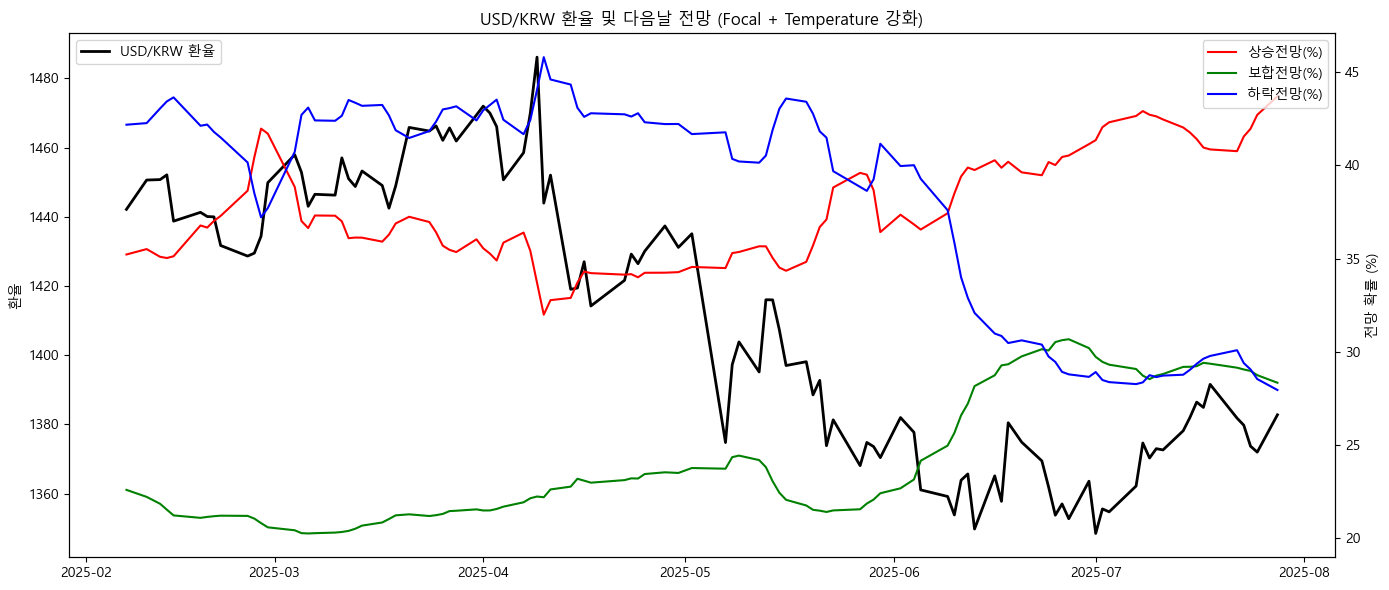

In [4]:
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib as mpl

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# ✅ 설정
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
tf.config.run_functions_eagerly(True)

# ✅ 데이터 수집
end_date = datetime.today().strftime('%Y-%m-%d')
start_date = (pd.Timestamp.today() - pd.DateOffset(years=2, months=7)).strftime('%Y-%m-%d')

tickers = {
    'KRW=X': '환율', 'CL=F': 'WTI유', 'GC=F': '금',
    '^GSPC': 'S&P500', '^DJI': '다우존스', 'CNY=X': '위안',
    '^N225': '닛케이', '^KS11': '코스피', '^IXIC': '나스닥', '^VIX': 'VIX'
}

df = pd.DataFrame()
for ticker, name in tickers.items():
    data = yf.download(ticker, start=start_date, end=end_date)[['Close']]
    data.rename(columns={'Close': name}, inplace=True)
    if df.empty:
        df = data
    else:
        df = df.join(data, how='outer')

df = df.dropna().reset_index()
df.rename(columns={'Date': '날짜'}, inplace=True)

# ✅ 기술적 지표 추가
df['MA20'] = df['환율'].rolling(window=20).mean()
df['STD20'] = df['환율'].rolling(window=20).std()
df['Upper'] = df['MA20'] + 2 * df['STD20']
df['Lower'] = df['MA20'] - 2 * df['STD20']
df['EMA12'] = df['환율'].ewm(span=12, adjust=False).mean()
df['EMA26'] = df['환율'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA12'] - df['EMA26']
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
delta = df['환율'].diff()
up = delta.clip(lower=0)
down = -delta.clip(upper=0)
ema_up = up.ewm(span=14, adjust=False).mean()
ema_down = down.ewm(span=14, adjust=False).mean()
rs = ema_up / ema_down
df['RSI'] = 100 - (100 / (1 + rs))

# ✅ 타깃: ±1원 기준 3분류
df['Target'] = df['환율'].shift(-1) - df['환율']
df['Target'] = df['Target'].apply(lambda x: 0 if abs(x) < 1 else (1 if x >= 1 else 2))
df = df.dropna().reset_index(drop=True)

# ✅ 피처 정의 및 스케일링
features = ['WTI유', '금', 'S&P500', '다우존스', '위안', '닛케이', '코스피', '나스닥', 'VIX',
            'MA20', 'Upper', 'Lower', 'MACD', 'Signal', 'RSI']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

# ✅ 시퀀스 생성
def create_sequences(data, targets, seq_len=30):
    X, y = [], []
    for i in range(len(data) - seq_len):
        X.append(data[i:i+seq_len])
        y.append(targets[i+seq_len])
    return np.array(X), np.array(y)

X, y = create_sequences(df[features].values, df['Target'].values, seq_len=30)
y_cat = to_categorical(y, num_classes=3)

X_train, X_val, y_train, y_val = train_test_split(X, y_cat, test_size=0.2, shuffle=False)

# ✅ Focal Loss
def focal_loss(gamma=2., alpha=0.25):
    def loss(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        weight = alpha * tf.pow(1 - y_pred, gamma)
        return tf.reduce_mean(weight * cross_entropy)
    return loss

# ✅ 모델 정의
model = Sequential([
    Bidirectional(LSTM(72, return_sequences=False)),
    Dropout(0.2),
    Dense(48, activation='relu'),
    Dense(3, activation='softmax')
])

model.compile(loss=focal_loss(), optimizer=Adam(0.0007), metrics=['accuracy'])

# ✅ 학습
model.fit(X_train, y_train, validation_data=(X_val, y_val),
          epochs=30, batch_size=32, verbose=1)

# ✅ 예측
logits = model.predict(X_val)

# ✅ Temperature 적용
def softmax_temperature(logits, T=0.7):
    exp_logits = np.exp(logits / T)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

probs = softmax_temperature(logits, T=0.7)

# ✅ 결과 병합
result = df.iloc[-len(probs):].copy()
result['상승전망(%)'] = probs[:,1] * 100
result['보합전망(%)'] = probs[:,0] * 100
result['하락전망(%)'] = probs[:,2] * 100
result['USD/KRW 환율'] = df['환율'].iloc[-len(probs):].values

# ✅ 시각화
plt.figure(figsize=(14, 6))
ax1 = plt.gca()
ax2 = ax1.twinx()

ax1.plot(result['날짜'], result['USD/KRW 환율'], color='black', label='USD/KRW 환율', linewidth=2)
ax2.plot(result['날짜'], result['상승전망(%)'], color='red', label='상승전망(%)')
ax2.plot(result['날짜'], result['보합전망(%)'], color='green', label='보합전망(%)')
ax2.plot(result['날짜'], result['하락전망(%)'], color='blue', label='하락전망(%)')

ax1.set_ylabel("환율")
ax2.set_ylabel("전망 확률 (%)")
plt.title("USD/KRW 환율 및 다음날 전망 (Focal + Temperature 강화)")
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')
plt.xlabel("날짜")
plt.tight_layout()
plt.show()
